# Set Parameter
- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100
- N = 100
- Data Length = 100K
- Data = [Ctype2, Ctype4, Ctype6, Ctype8]
- Deduplication

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from trainer.supervised_trainer import SupervisedTrainer
from trainer.supervised_trainer_unmatching import SupervisedTrainer_unmatching
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
data_name = ["Bracket_dedup_Ctype2", "Bracket_dedup_Ctype4", "Bracket_dedup_Ctype6", "Bracket_dedup_Ctype8"]
data_path = ["K100", "Ctype4", "Ctype6", "Ctype8"]
character_accuracy = []
sentence_accuracy = []

# Prepare dataset

In [ ]:
for i, j in zip(data_name, data_path):
    print("data : %s" % i)
    train_path = "../../../data/bracket_dedup/" + j + "/data_train.txt"
    dev_path = "../../../data/bracket_dedup/" + j + "/data_test.txt"

    src = fields.SourceField()
    tgt = fields.TargetField()
    max_len = 104
    def len_filter(example):
        return len(example.src) <= max_len and len(example.tgt) <= max_len
    train = torchtext.data.TabularDataset(
        path=train_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    dev = torchtext.data.TabularDataset(
        path=dev_path, format='tsv',
        fields=[('src', src), ('tgt', tgt)],
        filter_pred=len_filter
    )
    src.build_vocab(train)
    tgt.build_vocab(train)
    input_vocab = src.vocab
    output_vocab = tgt.vocab

    weight = torch.ones(len(tgt.vocab))
    pad = tgt.vocab.stoi[tgt.pad_token]
    loss = Perplexity(weight, pad)
    if torch.cuda.is_available():
        loss.cuda()
    
    optimizer = "Adam"
    hidden_size = 50
    bidirectional = True

    seq2seq = None
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                         bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                         dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                         eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer(loss=loss, batch_size=32,
                          checkpoint_every=50,
                          print_every=100,
                          hidden_size=hidden_size,
                          path="100K_number_of_ctype/" + i)

    seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list = t.train(seq2seq, train,
                                                                             num_epochs=100, dev_data=dev,
                                                                             optimizer=optimizer,
                                                                             teacher_forcing_ratio=0.5)

    character_accuracy.append(character_accuracy_list)
    sentence_accuracy.append(sentence_accuracy_list)
    torch_save_path = "../../../log/pth/100K_number_of_ctype_" + i + "_model_save.pth"
    torch.save(seq2seq.state_dict(), torch_save_path)

data : Bracket_dedup_Ctype2


/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-04-01 23:34:16,103 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
/home/hyeontae/hyeontae/venv2/lib/python3.5/site-packages/torch/nn/functional.py:1320: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-04-01 23:38:19,847 INFO   Finished epoch 1: Train loss: 13.8

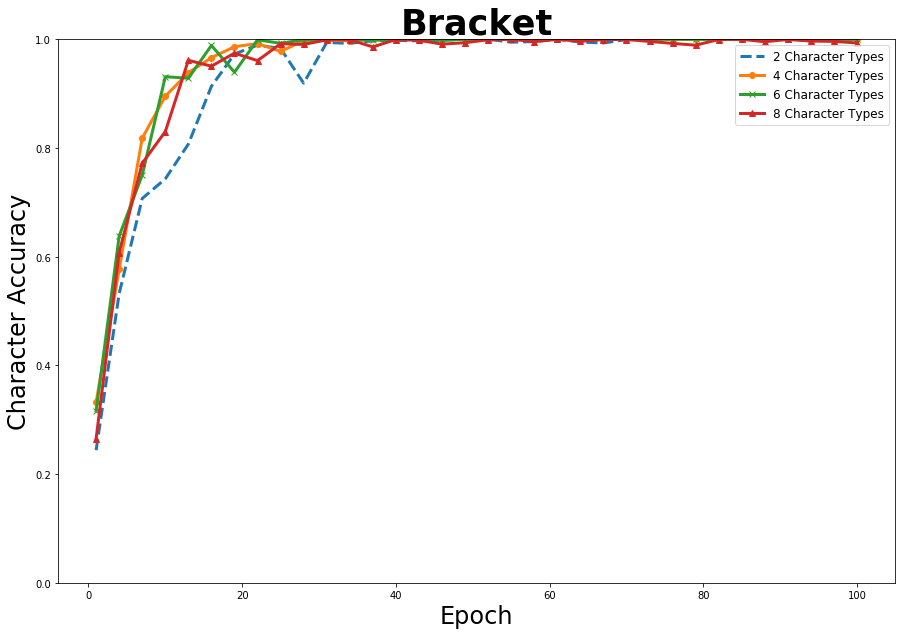

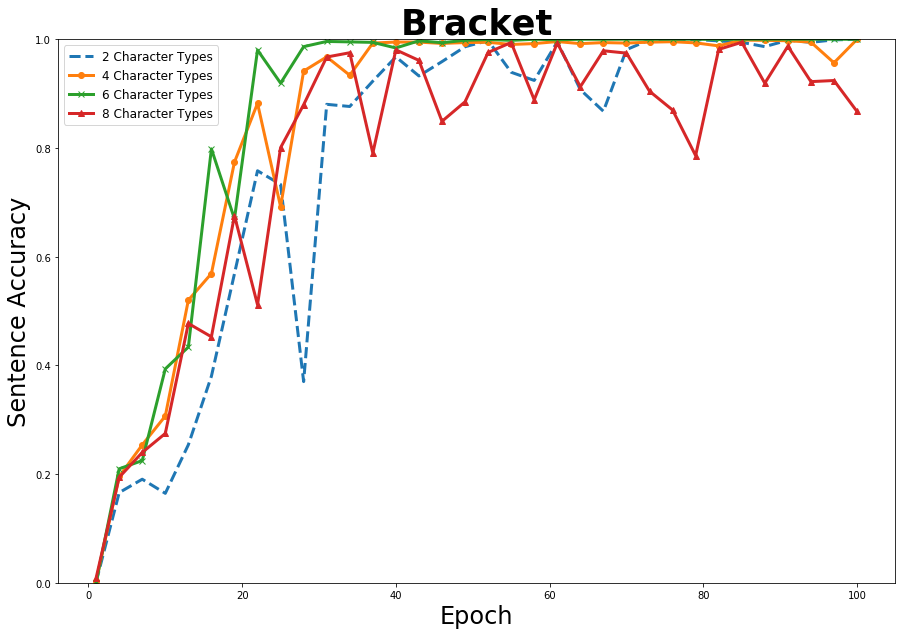

In [6]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], character_accuracy[0][::3], '--', LineWidth=3, label="2 Character Types")
plt.plot(epochs[::3], character_accuracy[1][::3], '-o', LineWidth=3, label="4 Character Types")
plt.plot(epochs[::3], character_accuracy[2][::3], '-x', LineWidth=3, label="6 Character Types")
plt.plot(epochs[::3], character_accuracy[3][::3], '-^', LineWidth=3, label="8 Character Types")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('Bracket', fontsize=35, fontweight=560)
plt.savefig('../../../log/plot/100K_number_of_ctype/bracket_dedup_number_of_ctype_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], sentence_accuracy[0][::3], '--', LineWidth=3, label="2 Character Types")
plt.plot(epochs[::3], sentence_accuracy[1][::3], '-o', LineWidth=3, label="4 Character Types")
plt.plot(epochs[::3], sentence_accuracy[2][::3], '-x', LineWidth=3, label="6 Character Types")
plt.plot(epochs[::3], sentence_accuracy[3][::3], '-^', LineWidth=3, label="8 Character Types")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentence Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.title('Bracket', fontsize=35, fontweight=560)
plt.savefig('../../../log/plot/100K_number_of_ctype/bracket_dedup_number_of_ctype_to_sentence_accuracy.png')

In [7]:
print(character_accuracy[0])
print(character_accuracy[1])
print(character_accuracy[2])
print(character_accuracy[3])

[0.24389155686941513, 0.41523454592331194, 0.449589827871436, 0.5322766154561004, 0.6029764528277354, 0.6469320029867784, 0.7070130335336948, 0.7316893304255905, 0.8203229047854425, 0.7430494141012783, 0.8201061944420808, 0.7163580297078012, 0.8070207140032168, 0.9107507133116559, 0.8584049672560232, 0.9132409701102259, 0.9404081611840543, 0.9363983824485018, 0.9727228602960837, 0.9800801764532102, 0.9673755325736361, 0.989006093066257, 0.9395990030049438, 0.9921525360368586, 0.9828907183916014, 0.9931611952085343, 0.9924830193104851, 0.9190484886206355, 0.9876927646471494, 0.9953193752750708, 0.9939056589763177, 0.994199811398263, 0.9915581760510213, 0.9924011155483616, 0.9968095775773632, 0.9815961927816972, 0.9970989496240872, 0.9995617989380556, 0.9990643212233681, 0.9976780124092167, 0.9987606080509804, 0.9544592774176031, 0.9970470028800167, 0.9993460446697382, 0.9969819897770082, 0.9982736471617797, 0.9642953774727686, 0.9993900241217734, 0.9995554251044273, 0.9836405999179688, 

In [8]:
print(sentence_accuracy[0])
print(sentence_accuracy[1])
print(sentence_accuracy[2])
print(sentence_accuracy[3])

[0.0015631931388495742, 0.035383087940176174, 0.13268129871775913, 0.16588859080250956, 0.18025306829464077, 0.18004182597858004, 0.19054056908679948, 0.17131751832527092, 0.2045459346416274, 0.1645788884429329, 0.20287712034474745, 0.1973636958955618, 0.2538921396734194, 0.31069519846215593, 0.27140412767485583, 0.379982678130083, 0.3959314729926699, 0.41152115591795346, 0.568685439067154, 0.7353556264390883, 0.6380151671982932, 0.757979678489195, 0.6245801558968292, 0.8028264221888929, 0.7327784701831471, 0.8702549694754853, 0.861171549884873, 0.37011766197004586, 0.8185217262722069, 0.8830351295971609, 0.8801833583303408, 0.8664526077863918, 0.8916538160924397, 0.8762120027883986, 0.9215023553518241, 0.7548744164431019, 0.9228331819430068, 0.9866917340881726, 0.9763197363695896, 0.9674475590950379, 0.9714400388685862, 0.6188977375947949, 0.932402458860559, 0.9765309786856503, 0.9179323602103974, 0.958765499904941, 0.6642092143898266, 0.9801854707535014, 0.9861425040664146, 0.7382496